In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/GrandmaCan/ML/main/Resgression/Salary_Data.csv'
data = pd.read_csv(url)

x = data['YearsExperience']
y = data['Salary']

In [3]:
#訓練集和測試集
from sklearn.model_selection import train_test_split
import torch

#預設為隨機分割資料 若想要分割的資料集為固定的可加上random_state並指定一數字(自訂)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=87)

#轉換為矩陣型式方便計算
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#使用torch工具需先將資料轉換為張量
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [4]:
from torch import nn

class LinearRegressionModel(nn.Module):#定義一個類別 並繼承nn
    def __init__(self):#初始化 代表當前類別的實例
        super().__init__()#調用父類別的構造函數
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        #定義了模型的權重 w 和偏置 b，並將它們初始化為隨機值。這裡使用了 nn.Parameter 封裝，表明這些參數需要進行梯度計算（即它們是需要訓練的參數）。
    
    def forward(self, x):#定義模型的前向傳播計算 即模型的訓練
        return self.w*x + self.b

In [5]:
torch.manual_seed(87)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('w', tensor([0.0036])), ('b', tensor([0.8931]))])

In [6]:
model(x_test)

tensor([0.9149, 0.9312, 0.8953, 0.9145, 0.9279, 0.9065, 0.8978],
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [7]:
#使用內建的cost function函式(距離平方差)
cost_fn = nn.MSELoss()
y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
print(model.state_dict())
print(cost)

#設定optimizer(Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01)
optimizer.zero_grad()#下行中每次計算之梯度(斜率)都會進行疊加 因此要歸零
cost.backward()#針對cost function進行微分 得知w,b的斜率
optimizer.step()#更新參數
y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
print(model.state_dict())
print(cost)

OrderedDict([('w', tensor([0.0036])), ('b', tensor([0.8931]))])
tensor(5627.4383, dtype=torch.float64, grad_fn=<MseLossBackward0>)
OrderedDict([('w', tensor([8.1354])), ('b', tensor([2.2939]))])
tensor(944.6858, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [8]:
epochs = 10000

train_cost_hist = []
test_cost_hist = []

for epoch in range(epochs):
    model.train()#現在是訓練階段
    y_pred = model(x_train)
    train_cost = cost_fn(y_pred, y_train)
    train_cost_hist.append(train_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()
    
    model.eval()#現在是測試階段
    with torch.inference_mode():#測試階段程式碼不需要追蹤梯度以提升運算速度
        test_pred = model(x_test)
        test_cost = cost_fn(test_pred, y_test)
        test_cost_hist.append(test_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
    
    if epoch%1000==0:
        print(f'Epoch: {epoch:5},  Train_Cost: {train_cost: .4e}, Test_Cost: {test_cost: .4e}')

Epoch:     0,  Train_Cost:  9.4469e+02, Test_Cost:  3.5138e+02
Epoch:  1000,  Train_Cost:  3.2599e+01, Test_Cost:  3.4706e+01
Epoch:  2000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4187e+01
Epoch:  3000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  4000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  5000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  6000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  7000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  8000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01
Epoch:  9000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4185e+01


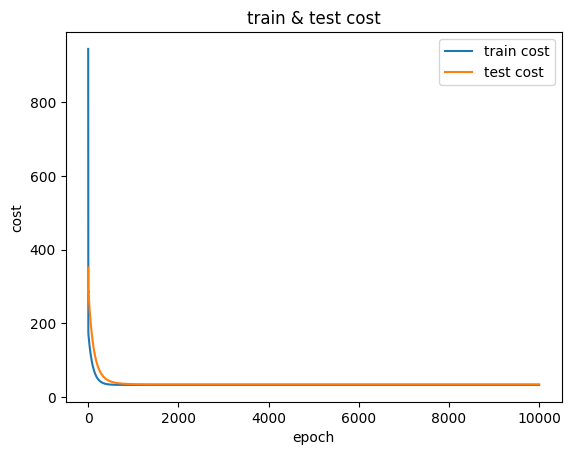

In [9]:
#繪製訓練集和測試集cost下降情形
import matplotlib.pyplot as plt
plt.plot(range(0,10000), train_cost_hist, label='train cost')
plt.plot(range(0,10000), test_cost_hist, label='test cost')
plt.title('train & test cost')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
plt.show()

In [10]:
model.w, model.b

(Parameter containing:
 tensor([9.3308], requires_grad=True),
 Parameter containing:
 tensor([26.6287], requires_grad=True))

In [11]:
model.eval()
with torch.inference_mode():
    y_pred = model(x_test)

y_pred, y_test

(tensor([ 82.6135, 124.6020,  32.2271,  81.6804, 116.2043,  61.1526,  38.7587],
        dtype=torch.float64),
 tensor([ 93.9000, 121.8000,  36.6000,  81.3000, 112.6000,  57.1000,  46.2000],
        dtype=torch.float64))

In [12]:
#儲存模型至資料夾以便後續直接使用
model.state_dict()
torch.save(obj=model.state_dict(), f='model/pytorch_linear_regression.pth')

In [17]:
#再創建一個模型(值為隨機)
model_1 = LinearRegressionModel()
model_1.state_dict()

OrderedDict([('w', tensor([0.5443])), ('b', tensor([0.1487]))])

In [15]:
#載入固定使用以訓練好的模型(值為固定)
model_1.load_state_dict(torch.load(f='model/pytorch_linear_regression.pth'))
model_1.state_dict()

OrderedDict([('w', tensor([9.3308])), ('b', tensor([26.6287]))])

In [16]:
model.eval()
with torch.inference_mode():
    y_pred = model_1(x_test)

y_pred, y_test

(tensor([ 82.6135, 124.6020,  32.2271,  81.6804, 116.2043,  61.1526,  38.7587],
        dtype=torch.float64),
 tensor([ 93.9000, 121.8000,  36.6000,  81.3000, 112.6000,  57.1000,  46.2000],
        dtype=torch.float64))

In [77]:
#不自訂參數 而是使用pytorch支援的工具自動創建
class LinearRegressionModel2(nn.Module):#定義一個類別 並繼承nn
    def __init__(self):#初始化 代表當前類別的實例
        super().__init__()#調用父類別的構造函數
        self.linear_layer = nn.Linear(in_features=1, out_features=1, dtype=torch.float64)#創建線性層

    
    def forward(self, x):#定義模型的前向傳播計算 即模型的訓練
        return self.linear_layer(x)

In [78]:
torch.manual_seed(87)
model_2 = LinearRegressionModel2()
model_2, model_2.state_dict()#參數的數量會隨著上方的設定更改

(LinearRegressionModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.9419]], dtype=torch.float64)),
              ('linear_layer.bias', tensor([0.2761], dtype=torch.float64))]))

In [84]:
x_train = x_train.reshape(-1,1)#-1表示不管 只在乎要轉變為?*1
y_train = y_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [85]:
#使用內建的cost function函式(距離平方差)
cost_fn = nn.MSELoss()
y_train = y_train.double()
y_pred = model_2(x_train)
cost = cost_fn(y_pred, y_train)
print(model_2.state_dict())
print(cost)

#設定optimizer(Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_2.parameters(), lr=0.01)
optimizer.zero_grad()#下行中每次計算之梯度(斜率)都會進行疊加 因此要歸零
cost.backward()#針對cost function進行微分 得知w,b的斜率
optimizer.step()#更新參數

y_pred = model_2(x_train)
cost = cost_fn(y_pred, y_train)
print(model_2.state_dict())
print(cost)

OrderedDict([('linear_layer.weight', tensor([[12.0841]], dtype=torch.float64)), ('linear_layer.bias', tensor([2.9273], dtype=torch.float64))])
tensor(205.5102, dtype=torch.float64, grad_fn=<MseLossBackward0>)
OrderedDict([('linear_layer.weight', tensor([[12.6570]], dtype=torch.float64)), ('linear_layer.bias', tensor([3.1398], dtype=torch.float64))])
tensor(179.3835, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [76]:
qq = x_train.reshape(26,1)#x_train(1*26)要跟w(1*1)相乘要變形
#qq = qq.type(torch.float32)#兩個矩陣相乘需要一樣的資料型態
#x_train.dtype, model_2.linear_layer.weight.dtype
model_2(qq) 
qq.dtype, model_2.linear_layer.weight.dtype

(torch.float64, torch.float64)

In [86]:
epochs = 10000

train_cost_hist = []
test_cost_hist = []

for epoch in range(epochs):
    model_2.train()#現在是訓練階段
    y_pred = model_2(x_train)
    train_cost = cost_fn(y_pred, y_train)
    train_cost_hist.append(train_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()
    
    model_2.eval()#現在是測試階段
    with torch.inference_mode():#測試階段程式碼不需要追蹤梯度以提升運算速度
        test_pred = model_2(x_test)
        test_cost = cost_fn(test_pred, y_test)
        test_cost_hist.append(test_cost.detach().numpy())#detach()將有追蹤梯度的張量轉換成沒有追蹤梯度的張量(用於繪圖)
    
    if epoch%1000==0:
        print(f'Epoch: {epoch:5},  Train_Cost: {train_cost: .4e}, Test_Cost: {test_cost: .4e}')

Epoch:     0,  Train_Cost:  1.7938e+02, Test_Cost:  2.9117e+02
Epoch:  1000,  Train_Cost:  3.2599e+01, Test_Cost:  3.4703e+01
Epoch:  2000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4187e+01
Epoch:  3000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  4000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  5000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  6000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  7000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  8000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01
Epoch:  9000,  Train_Cost:  3.2594e+01, Test_Cost:  3.4184e+01


In [87]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[9.3308]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([26.6288], dtype=torch.float64))])